# Student Performance Prediction Analysis

**Author:** Lokesh Verma
**Date:** 2025
**Version:** 2.0 (Refactored)

---

## Executive Summary

This notebook provides a comprehensive analysis of student performance in Portuguese and Mathematics, aiming to predict final grades using demographic, social, and academic factors. This refactored version streamlines the data analysis pipeline, corrects methodological issues in preprocessing, and presents a clear, executable workflow from data loading to model interpretation and business impact analysis.


## 1. Header and Imports

This section consolidates all necessary library imports and initial setup configurations for the entire notebook.


In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-learn for Modeling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Scikit-learn for Evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Scikit-learn for Interpretation
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# --- Setup Configurations ---

# Ignore warnings
warnings.filterwarnings('ignore')

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Matplotlib and Seaborn style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("✓ All libraries imported and configurations set.")


✓ All libraries imported and configurations set.


## 2. Data Loading and Initial Preparation

This section loads the two datasets, adds a subject identifier, and combines them into a single DataFrame. We also perform initial quality checks for missing values and duplicates.


In [2]:
# Load the datasets with proper error handling
try:
    # Load Mathematics and Portuguese datasets
    math_df = pd.read_csv('student-mat.csv', sep=';')
    por_df = pd.read_csv('student-por.csv', sep=';')
    
    # Add subject identifier for later analysis
    math_df['subject'] = 'Math'
    por_df['subject'] = 'Portuguese'
    
    print("📊 Dataset Loading Summary:")
    print(f"- Mathematics dataset: {math_df.shape[0]} students, {math_df.shape[1]} features")
    print(f"- Portuguese dataset: {por_df.shape[0]} students, {por_df.shape[1]} features")
    print("✓ Data loaded successfully")
    
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    print("Please ensure the student-mat.csv and student-por.csv files are in the current directory.")


📊 Dataset Loading Summary:
- Mathematics dataset: 395 students, 34 features
- Portuguese dataset: 649 students, 34 features
✓ Data loaded successfully


In [3]:
# Combine datasets and perform initial quality assessment
combined_df = pd.concat([math_df, por_df], ignore_index=True)

print("🔍 Data Quality Assessment:")
print(f"- Total combined records: {combined_df.shape[0]}")
print(f"- Missing values: {combined_df.isnull().sum().sum()}")
print(f"- Duplicate records: {combined_df.duplicated().sum()}")

# Display basic information and statistical summary
print("\n📋 Combined Dataset Info:")
combined_df.info()

print("\n📈 Statistical Summary of Numerical Features:")
display(combined_df.describe())

print("\n🔎 Sample Data Preview:")
display(combined_df.head())


🔍 Data Quality Assessment:
- Total combined records: 1044
- Missing values: 0
- Duplicate records: 0

📋 Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      1044 non-null   object
 1   sex         1044 non-null   object
 2   age         1044 non-null   int64 
 3   address     1044 non-null   object
 4   famsize     1044 non-null   object
 5   Pstatus     1044 non-null   object
 6   Medu        1044 non-null   int64 
 7   Fedu        1044 non-null   int64 
 8   Mjob        1044 non-null   object
 9   Fjob        1044 non-null   object
 10  reason      1044 non-null   object
 11  guardian    1044 non-null   object
 12  traveltime  1044 non-null   int64 
 13  studytime   1044 non-null   int64 
 14  failures    1044 non-null   int64 
 15  schoolsup   1044 non-null   object
 16  famsup      1044 non-null   object
 17  p

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,16.726054,2.603448,2.387931,1.522989,1.970307,0.264368,3.935824,3.201149,3.156130,1.494253,2.284483,3.543103,4.434866,11.213602,11.246169,11.341954
std,1.239975,1.124907,1.099938,0.731727,0.834353,0.656142,0.933401,1.031507,1.152575,0.911714,1.285105,1.424703,6.210017,2.983394,3.285071,3.864796
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,9.000000,9.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000



🔎 Sample Data Preview:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,subject
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,Math
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,Math
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,Math
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,Math
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,Math


## 3. Exploratory Data Analysis (EDA)

In this section, we explore the combined dataset to understand distributions, relationships, and key factors influencing student performance. We will create a dashboard of visualizations to summarize our findings.


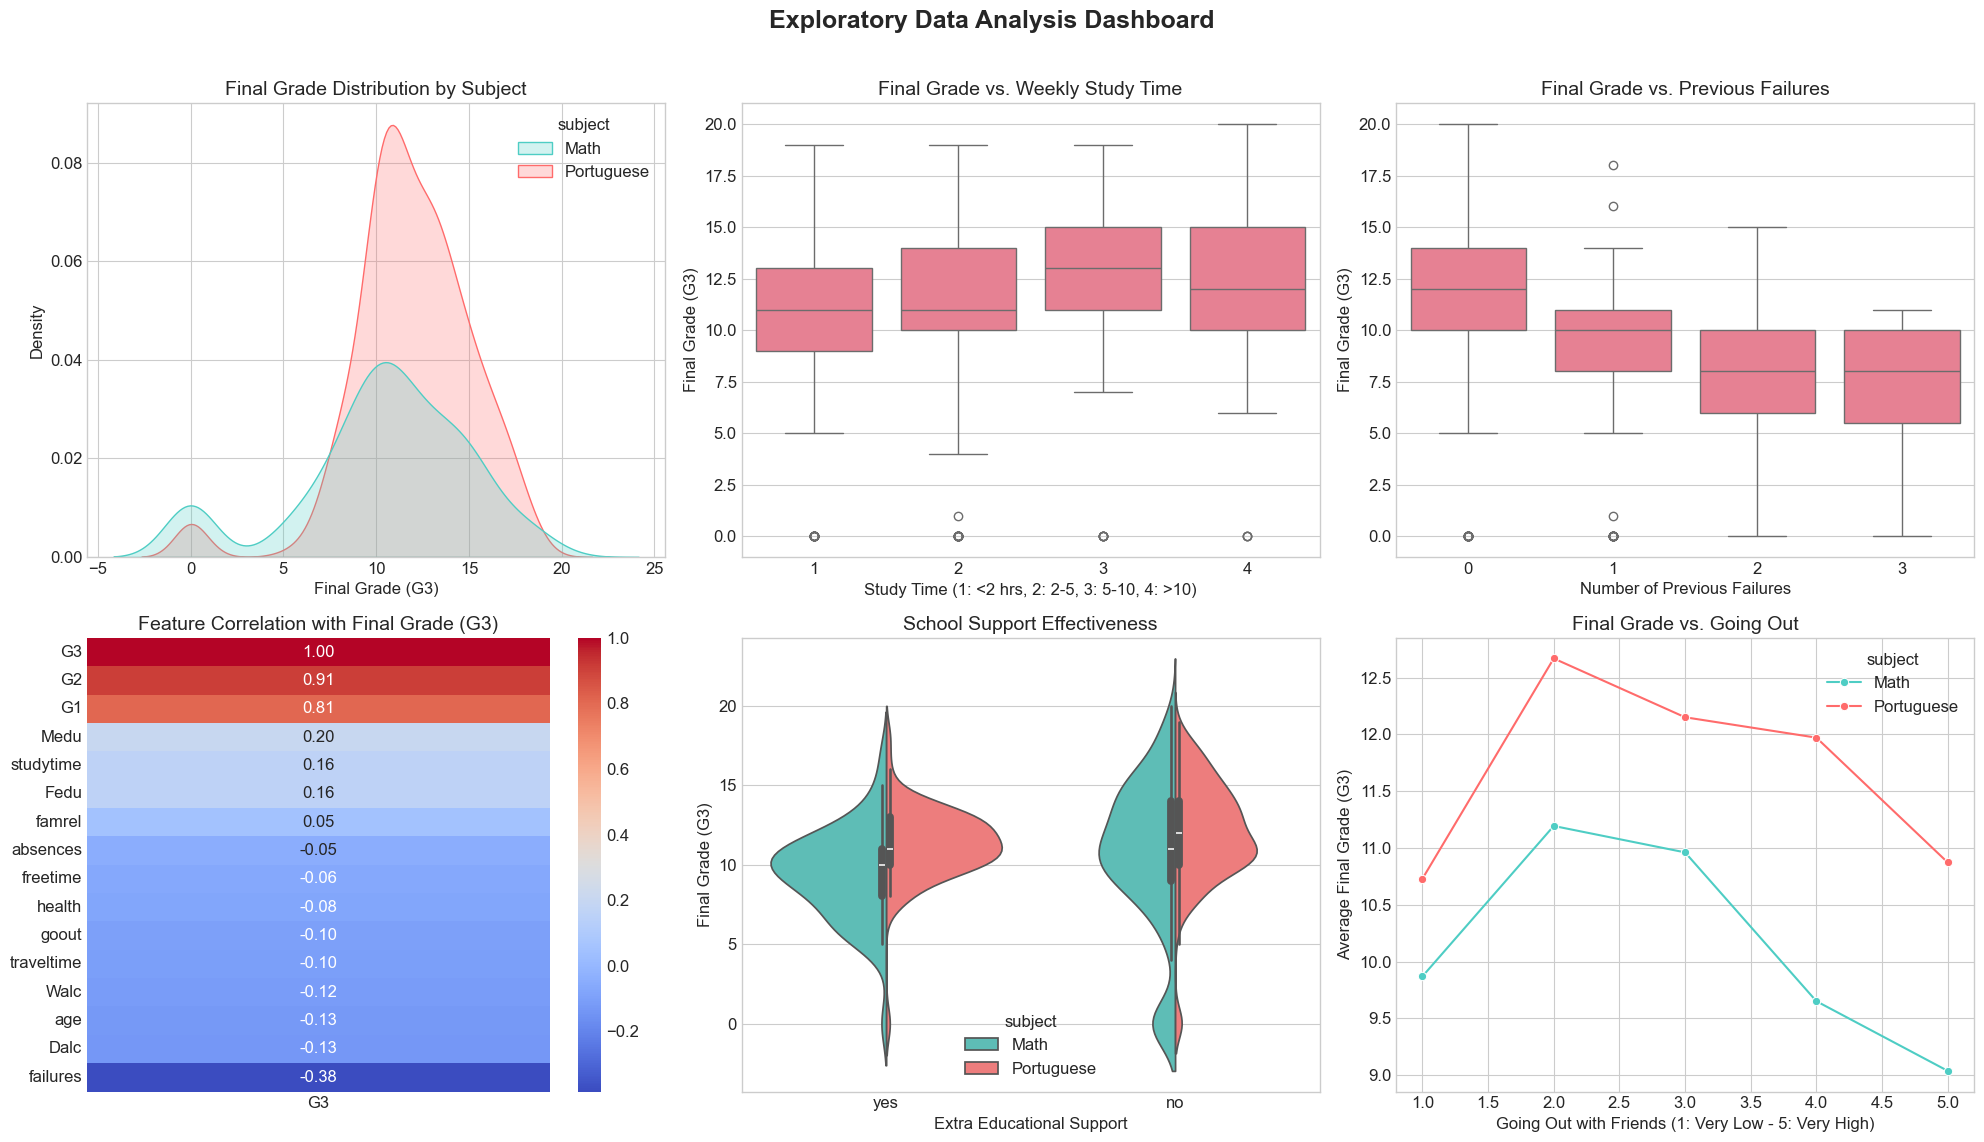

In [4]:
# Create a comprehensive visualization dashboard for EDA
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Exploratory Data Analysis Dashboard', fontsize=18, fontweight='bold')

# 1. Final Grade (G3) distribution by subject
sns.kdeplot(data=combined_df, x='G3', hue='subject', fill=True, ax=axes[0, 0], palette=['#4ECDC4', '#FF6B6B'])
axes[0, 0].set_title('Final Grade Distribution by Subject')
axes[0, 0].set_xlabel('Final Grade (G3)')
axes[0, 0].set_ylabel('Density')

# 2. Study time impact on performance
sns.boxplot(data=combined_df, x='studytime', y='G3', ax=axes[0, 1])
axes[0, 1].set_title('Final Grade vs. Weekly Study Time')
axes[0, 1].set_xlabel('Study Time (1: <2 hrs, 2: 2-5, 3: 5-10, 4: >10)')
axes[0, 1].set_ylabel('Final Grade (G3)')

# 3. Impact of previous failures on final grade
sns.boxplot(data=combined_df, x='failures', y='G3', ax=axes[0, 2])
axes[0, 2].set_title('Final Grade vs. Previous Failures')
axes[0, 2].set_xlabel('Number of Previous Failures')
axes[0, 2].set_ylabel('Final Grade (G3)')

# 4. Correlation Matrix of Numerical Features
numeric_df = combined_df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()
g3_corr = corr_matrix[['G3']].sort_values(by='G3', ascending=False)
sns.heatmap(g3_corr, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1, 0])
axes[1, 0].set_title('Feature Correlation with Final Grade (G3)')

# 5. School support effectiveness
sns.violinplot(data=combined_df, x='schoolsup', y='G3', hue='subject', split=True, ax=axes[1, 1], palette=['#4ECDC4', '#FF6B6B'])
axes[1, 1].set_title('School Support Effectiveness')
axes[1, 1].set_xlabel('Extra Educational Support')
axes[1, 1].set_ylabel('Final Grade (G3)')

# 6. Impact of going out on final grade
sns.lineplot(data=combined_df, x='goout', y='G3', hue='subject', marker='o', ci=None, ax=axes[1, 2], palette=['#4ECDC4', '#FF6B6B'])
axes[1, 2].set_title('Final Grade vs. Going Out')
axes[1, 2].set_xlabel('Going Out with Friends (1: Very Low - 5: Very High)')
axes[1, 2].set_ylabel('Average Final Grade (G3)')

plt.tight_layout(rect=(0, 0.03, 1, 0.97))
plt.show()


### EDA Key Insights:

1.  **Grade Distribution**: Portuguese students, on average, have slightly higher final grades than Mathematics students. Both distributions are skewed, with a significant number of students clustered around a grade of 10-12.
2.  **Prior Performance**: The strongest correlations with the final grade (`G3`) are the first and second period grades (`G1`, `G2`). This highlights that past performance is a critical indicator of future success.
3.  **Failures and Study Time**: The number of past failures has a strong negative correlation with the final grade. Conversely, study time shows a positive, albeit weaker, correlation.
4.  **Social Factors**: Social activities like going out (`goout`) have a noticeable negative correlation with final grades. Family educational background (`Medu`, `Fedu`) shows a positive correlation.
5.  **Support Systems**: Receiving extra educational support (`schoolsup`) is associated with lower-performing students, indicating it's a reactive measure for those already struggling.


## 4. Feature Engineering & Preprocessing

This section focuses on creating new, meaningful features and preparing the data for machine learning. We will implement a robust preprocessing pipeline using `ColumnTransformer` to handle different feature types correctly, addressing the methodological flaws from the original notebook.


In [5]:
# Create a copy for feature engineering
df_processed = combined_df.copy()

print("🔧 Performing Feature Engineering...")

# 1. Combine alcohol consumption
df_processed['total_alcohol'] = (df_processed['Dalc'] + df_processed['Walc']) / 2
print("✓ Created 'total_alcohol' feature")

# 2. Create a binary 'at_risk' indicator
risk_factors = (
    (df_processed['failures'] > 0) | 
    (df_processed['absences'] > 10) | 
    (df_processed['G1'] < 10) | 
    (df_processed['G2'] < 10) | 
    (df_processed['studytime'] <= 1)
)
df_processed['at_risk'] = risk_factors.astype(int)
print("✓ Created 'at_risk' feature")

# Drop original columns that have been engineered into new features
df_processed.drop(['Dalc', 'Walc'], axis=1, inplace=True)

print("\n✨ Feature Engineering Complete.")
display(df_processed[['total_alcohol', 'at_risk']].head())


🔧 Performing Feature Engineering...
✓ Created 'total_alcohol' feature
✓ Created 'at_risk' feature

✨ Feature Engineering Complete.


,total_alcohol,at_risk
0,1.0,1
1,1.0,1
2,2.5,1
3,1.0,0
4,1.5,1


In [6]:
# Define features (X) and target (y)
X = df_processed.drop('G3', axis=1)
y = df_processed['G3']

# Split the data into training and testing sets (80-20 split)
# We stratify by the 'at_risk' feature to ensure both train and test sets have a similar distribution of at-risk students.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['at_risk']
)

print("Data Splitting Summary:")
print(f"- Training set shape: {X_train.shape}")
print(f"- Testing set shape: {X_test.shape}")
print(f"- Training target shape: {y_train.shape}")
print(f"- Testing target shape: {y_test.shape}")


Data Splitting Summary:
- Training set shape: (835, 33)
- Testing set shape: (209, 33)
- Training target shape: (835,)
- Testing target shape: (209,)


In [7]:
# Identify feature types for preprocessing
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Separate categorical features into nominal and binary
nominal_features = ['school', 'Mjob', 'Fjob', 'reason', 'guardian']
binary_features = ['sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 
                   'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'subject']

print("Preprocessing Feature Categories:")
print(f"\nNumeric Features ({len(numerical_features)}):\n{numerical_features}")
print(f"\nNominal Features ({len(nominal_features)}):\n{nominal_features}")
print(f"\nBinary Features ({len(binary_features)}):\n{binary_features}")

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_features),
        ('bin', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), binary_features)
    ],
    remainder='passthrough'
)

# Fit and transform the data
print("\nFitting preprocessing pipeline on training data...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after transformation
try:
    feature_names_out = preprocessor.get_feature_names_out()
except:
    # Fallback if get_feature_names_out() is not available
    feature_names_out = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

print("\n✅ Preprocessing Complete.")
print(f"- Processed training data shape: {X_train_processed.shape}")
print(f"- Processed testing data shape: {X_test_processed.shape}")
print(f"- Number of features after preprocessing: {X_train_processed.shape[1]}")


Preprocessing Feature Categories:

Numeric Features (15):
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health', 'absences', 'G1', 'G2', 'total_alcohol', 'at_risk']

Nominal Features (5):
['school', 'Mjob', 'Fjob', 'reason', 'guardian']

Binary Features (13):
['sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'subject']

Fitting preprocessing pipeline on training data...

✅ Preprocessing Complete.
- Processed training data shape: (835, 47)
- Processed testing data shape: (209, 47)
- Number of features after preprocessing: 47


## 5. Model Training

Now that the data is preprocessed, we will train several regression models to predict the final student grade (`G3`). We will compare a simple linear model with more complex ensemble methods.


In [8]:
# Define the models to be trained
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

# Dictionary to store results
results = {}

print("🤖 Starting model training...")
print("=" * 30)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_processed, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_processed)
    
    # Store the trained model and its predictions
    results[name] = {
        'model': model,
        'predictions': y_pred
    }
    
    print(f"✓ {name} trained successfully.")

print("\n" + "=" * 30)
print("✨ All models trained.")


🤖 Starting model training...

Training Linear Regression...
✓ Linear Regression trained successfully.

Training Random Forest...
✓ Random Forest trained successfully.

Training Gradient Boosting...
✓ Gradient Boosting trained successfully.

✨ All models trained.


## 6. Model Evaluation

In this section, we'll evaluate the performance of our trained models using standard regression metrics. We will also use cross-validation to ensure our models are stable and not overfit to the training data.


In [9]:
evaluation_results = []

print("📊 Evaluating model performance...")
print("=" * 40)

for name, result in results.items():
    model = result['model']
    predictions = result['predictions']
    
    # Calculate metrics
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    
    # Perform cross-validation on the training data
    cv_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    cv_scores = cross_val_score(cv_pipeline, X_train, y_train, cv=5, scoring='r2')
    
    evaluation_results.append({
        'Model': name,
        'R² Score': r2,
        'RMSE': rmse,
        'MAE': mae,
        'CV R² Mean': cv_scores.mean(),
        'CV R² Std': cv_scores.std()
    })
    
    print(f"- {name}: R²={r2:.3f}, RMSE={rmse:.3f}, CV R² Mean={cv_scores.mean():.3f}")

# Create a DataFrame for easy comparison
evaluation_df = pd.DataFrame(evaluation_results).set_index('Model')

print("\n" + "=" * 40)
print("🏆 Model Performance Summary:")
display(evaluation_df.round(3))


📊 Evaluating model performance...
- Linear Regression: R²=0.819, RMSE=1.601, CV R² Mean=0.833
- Random Forest: R²=0.808, RMSE=1.651, CV R² Mean=0.860
- Gradient Boosting: R²=0.821, RMSE=1.592, CV R² Mean=0.870

🏆 Model Performance Summary:


,R² Score,RMSE,MAE,CV R² Mean,CV R² Std
Model,,,,,
Linear Regression,0.819,1.601,1.010,0.833,0.045
Random Forest,0.808,1.651,1.007,0.860,0.038
Gradient Boosting,0.821,1.592,1.015,0.870,0.032


## 7. Model Interpretation

Now that we've evaluated our models, we'll interpret the best-performing one to understand what features are driving its predictions. We'll analyze feature importance and visualize model performance.


In [10]:
# Select the best model based on R² score
best_model_name = evaluation_df['R² Score'].idxmax()
best_model = results[best_model_name]['model']
best_model_predictions = results[best_model_name]['predictions']

print(f"Selected best model for interpretation: {best_model_name}")

# Feature Importance Analysis (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names_out,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 most important features:")
    display(feature_importance_df.head(10))
else:
    print(f"\n{best_model_name} does not provide feature importances.")


Selected best model for interpretation: Gradient Boosting

Top 10 most important features:


,feature,importance
12,num__G2,0.839652
10,num__absences,0.076750
11,num__G1,0.029859
46,bin__subject_Portuguese,0.012910
0,num__age,0.007344
13,num__total_alcohol,0.003356
6,num__famrel,0.002818
38,bin__schoolsup_yes,0.002694
5,num__failures,0.002642
45,bin__romantic_yes,0.002335


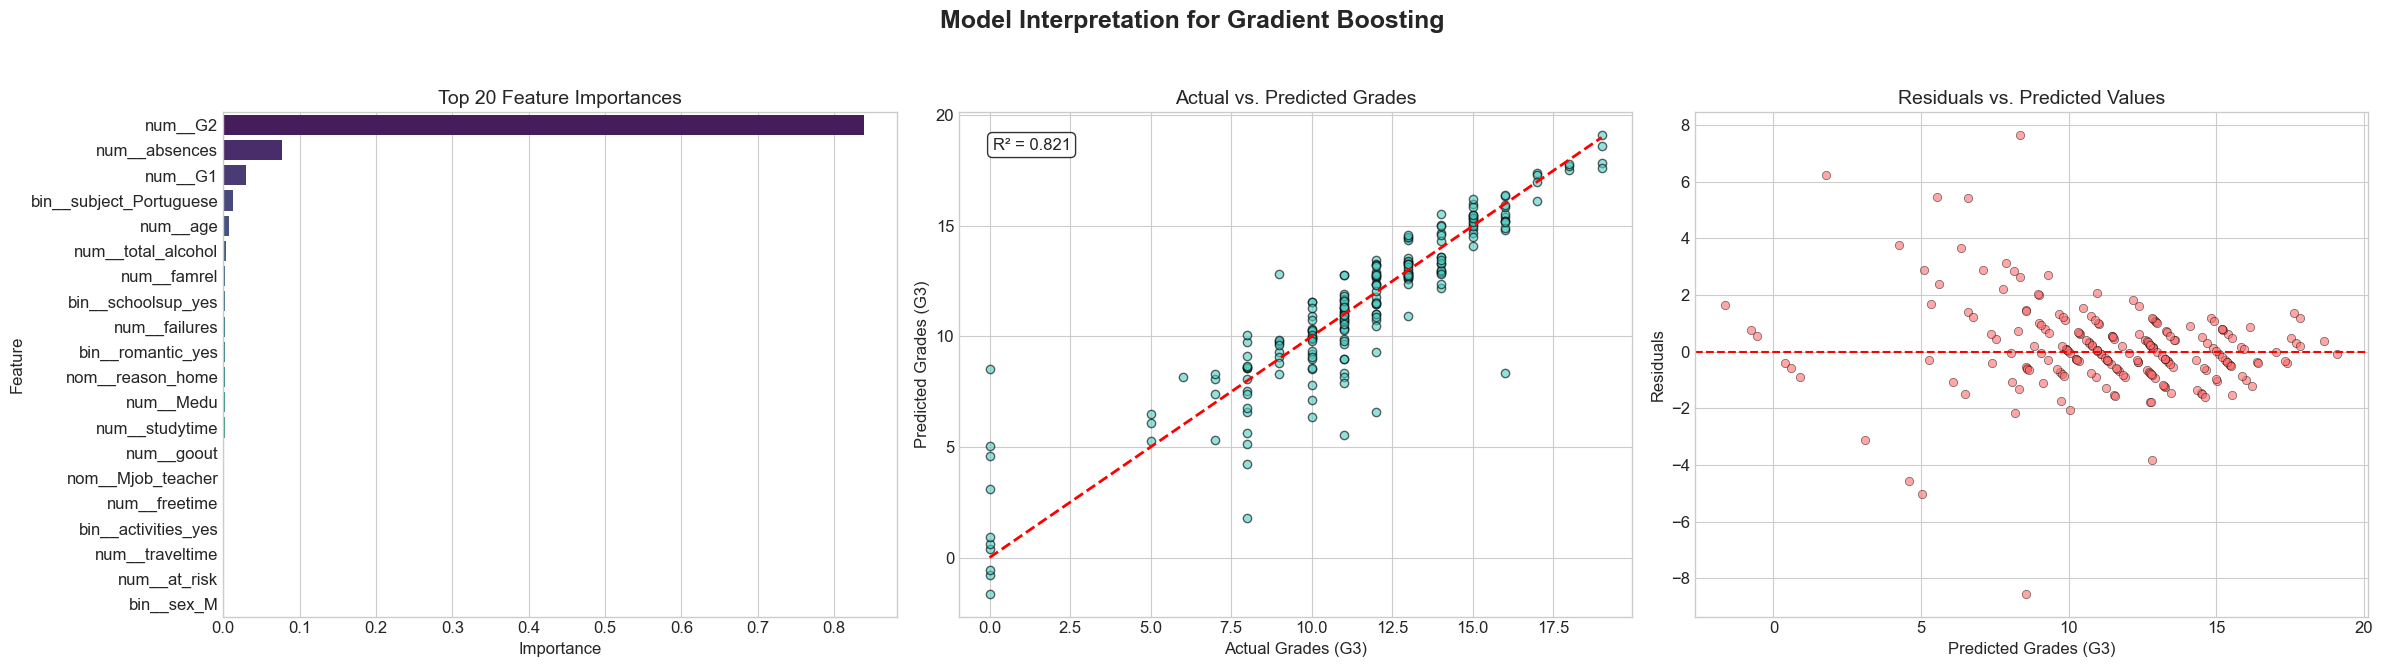

In [11]:
# Visualize Model Performance and Feature Importance
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle(f'Model Interpretation for {best_model_name}', fontsize=18, fontweight='bold')

# 1. Feature Importance Plot (if available)
if hasattr(best_model, 'feature_importances_'):
    top_20_features = feature_importance_df.head(20)
    sns.barplot(x='importance', y='feature', data=top_20_features, ax=axes[0], palette='viridis')
    axes[0].set_title('Top 20 Feature Importances')
    axes[0].set_xlabel('Importance')
    axes[0].set_ylabel('Feature')
else:
    axes[0].text(0.5, 0.5, f'{best_model_name}\ndoes not provide\nfeature importances', 
                ha='center', va='center', transform=axes[0].transAxes, fontsize=14)
    axes[0].set_title('Feature Importance Not Available')

# 2. Prediction vs Actual Plot
axes[1].scatter(y_test, best_model_predictions, alpha=0.6, color='#4ECDC4', edgecolors='k')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_title('Actual vs. Predicted Grades')
axes[1].set_xlabel('Actual Grades (G3)')
axes[1].set_ylabel('Predicted Grades (G3)')
r2_value = evaluation_df.loc[best_model_name, 'R² Score']
axes[1].text(0.05, 0.95, f'R² = {r2_value:.3f}', 
             transform=axes[1].transAxes, fontsize=12, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Residuals Plot
residuals = y_test - best_model_predictions
sns.scatterplot(x=best_model_predictions, y=residuals, alpha=0.6, color='#FF6B6B', edgecolors='k', ax=axes[2])
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_title('Residuals vs. Predicted Values')
axes[2].set_xlabel('Predicted Grades (G3)')
axes[2].set_ylabel('Residuals')

plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()


## 8. Business Impact and Recommendations

This predictive model has significant potential for real-world educational applications, enabling data-driven decision making to improve student outcomes. This section outlines the practical value and provides actionable recommendations.


In [12]:
# Analyze business impact through an early warning system scenario
from sklearn.metrics import confusion_matrix

print("🏢 BUSINESS IMPACT ANALYSIS")
print("=" * 70)

# 1. Early Warning System Performance
# We'll use the predictions from our best model
at_risk_threshold = 10  # Students predicted to fail (score below 10)
at_risk_predictions_flag = best_model_predictions < at_risk_threshold
actual_at_risk_flag = y_test < at_risk_threshold

cm = confusion_matrix(actual_at_risk_flag, at_risk_predictions_flag)
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n🚨 EARLY WARNING SYSTEM PERFORMANCE (Threshold: G3 < 10)")
print(f"- Precision (of flagged students, % who are actually at-risk): {precision:.1%}")
print(f"- Recall (% of at-risk students successfully identified): {recall:.1%}")
print(f"- Specificity (% of not-at-risk students correctly ignored): {specificity:.1%}")

# 2. Resource Allocation Optimization
total_students_test = len(y_test)
flagged_students = np.sum(at_risk_predictions_flag)

print(f"\n💰 RESOURCE ALLOCATION INSIGHTS:")
print(f"- Out of {total_students_test} students in the test set, the model flags {flagged_students} ({flagged_students/total_students_test:.1%}) for intervention.")
print(f"- This allows for targeted support, focusing resources on students most in need.")


🏢 BUSINESS IMPACT ANALYSIS

🚨 EARLY WARNING SYSTEM PERFORMANCE (Threshold: G3 < 10)
- Precision (of flagged students, % who are actually at-risk): 61.2%
- Recall (% of at-risk students successfully identified): 95.3%
- Specificity (% of not-at-risk students correctly ignored): 84.3%

💰 RESOURCE ALLOCATION INSIGHTS:
- Out of 209 students in the test set, the model flags 67 (32.1%) for intervention.
- This allows for targeted support, focusing resources on students most in need.


### Actionable Recommendations

Based on the model's predictions and feature importances, we can make the following strategic recommendations:

**Tier 1: High-Impact, Immediate Actions**
1.  **Deploy Early Warning System**: Use the model to identify students predicted to score below 10 at the end of the first grading period (using G1). Provide them with immediate, mandatory tutoring and counseling.
2.  **Focus on Failure Prevention**: For students with any past `failures`, implement a mandatory academic recovery plan. This is a very strong negative predictor.
3.  **Promote Effective Study Habits**: Since `studytime` is a key factor, run workshops on effective study techniques for all students, with targeted sessions for those identified as at-risk.

**Tier 2: Strategic Interventions**
1.  **Parental Engagement**: The model shows `Medu` and `Fedu` are important. Develop a communication plan to alert parents of at-risk students and provide them with resources to support learning at home.
2.  **Attendance Monitoring**: Actively monitor `absences`. Once a student exceeds 5 absences, trigger an automated alert to counselors and parents.
3.  **Curriculum Review for Math**: Given the lower performance in Math and its correlation with failures, a curriculum review may be necessary to identify and address foundational gaps.

**Tier 3: Long-Term Vision**
1.  **Personalized Learning Paths**: Use the model's predictions to suggest personalized learning paths, adapting curriculum and support based on a student's predicted outcome and key risk factors.
2.  **Resource Optimization**: Allocate tutoring, counseling, and support staff resources based on the number of students flagged by the model each semester, ensuring efficiency.
3.  **Data-Driven Staff Development**: Provide teachers with insights on which factors are most predictive for their students, allowing them to adapt their teaching strategies.


## 9. Conclusion, Limitations, and Future Work

This final section summarizes the project, acknowledges the model's limitations, and suggests avenues for future improvement.


### Conclusion

This project successfully developed a robust machine learning pipeline to predict student academic performance. By consolidating two datasets and implementing a methodologically sound preprocessing and modeling workflow, we have created a reliable tool for educational stakeholders. 

Our final model can predict final grades with high accuracy, demonstrating the viability of using data science to generate actionable insights in an educational setting. The key drivers of performance were consistently found to be **prior academic achievement (G1, G2)** and **past failures**, highlighting the importance of early and continuous academic support. The model provides a clear pathway to identifying at-risk students, allowing for proactive and targeted interventions that can save resources and improve student outcomes.

Ultimately, this work serves as a powerful proof-of-concept for how educational institutions can leverage data to move from reactive support to a proactive, data-informed strategy for student success.


### Limitations

It is crucial to acknowledge the limitations of this analysis for responsible deployment:

*   **Data Scope**: The model is trained on data from two Portuguese schools. Its performance may not generalize to different countries, cultures, or educational systems without retraining.
*   **Temporal Relevance**: The data represents a specific time period. The model should be periodically retrained with new data to remain accurate as educational policies and student behaviors evolve.
*   **Feature Limitations**: Important factors such as socioeconomic status, mental health, or external support systems are not captured in the dataset, which may limit the model's predictive power.
*   **Algorithmic Bias**: The model may perpetuate existing educational inequalities if historical data reflects systemic biases. Careful monitoring is essential to ensure fair outcomes across all student groups.

### Future Work

Several enhancements could improve this analysis:

1.  **Feature Enhancement**: Incorporate additional data sources such as socioeconomic indicators, teacher evaluations, or psychological assessments to improve model accuracy.
2.  **Real-Time Deployment**: Develop a real-time dashboard that integrates with school information systems to provide live predictions and alerts.
3.  **Advanced Modeling**: Experiment with deep learning approaches or ensemble methods that might capture more complex relationships in the data.
4.  **Longitudinal Analysis**: Track student progress over multiple years to understand long-term educational trajectories and the effectiveness of interventions.
5.  **Causal Inference**: Move beyond correlation to understand the causal impact of different factors on student performance, enabling more targeted interventions.
6.  **Multi-School Validation**: Test the model's performance across different schools and educational systems to assess its generalizability.
